In [27]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

In [2]:
MODEL_DIR = 'saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

In [3]:
data = pd.read_csv('data/cleaned_tweets.csv', encoding = 'latin1')
print(data.shape)
data = data[~data['text_cleaned'].isna()]
print(data.shape)
df = data[['sentiment', 'text_cleaned']]

(1600000, 7)
(1596818, 7)


In [4]:
data.head(5)

,sentiment,id,date,query,user_id,text,text_cleaned
0,negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that is a bummer you shoulda get david car...
1,negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can not update his facebook b...
2,negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,i dive many time for the ball manage to save 5...
3,negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,my whole body feel itchy and like it on fire
4,negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",no it is not behave at all i am mad why am i h...


In [5]:
df.head(2)

,sentiment,text_cleaned
0,negative,aww that is a bummer you shoulda get david car...
1,negative,is upset that he can not update his facebook b...


In [6]:
df.columns

Index(['sentiment', 'text_cleaned'], dtype='object')

## Data Split

In [7]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [8]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=77) 

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1277454
Test Data size 319364


In [9]:
train_data_rf, test_data_rf = train_test_split(df, test_size=0.5,
                                         random_state=77) 

print("Train Data size:", len(train_data_rf))
print("Test Data size", len(test_data_rf))

Train Data size: 798409
Test Data size 798409


In [10]:
train_data['sentiment'].value_counts()

sentiment
positive    639151
negative    638303
Name: count, dtype: int64

In [11]:
test_data['sentiment'].value_counts()

sentiment
negative    160087
positive    159277
Name: count, dtype: int64

# Model Training

## Preprocessing

In [12]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_data['text_cleaned'])
X_test = vectorizer.transform(test_data['text_cleaned'])

In [13]:
vectorizer_rf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_rf = vectorizer_rf.fit_transform(train_data_rf['text_cleaned'])
X_test_rf = vectorizer_rf.transform(test_data_rf['text_cleaned'])

In [14]:
vectorizer_path = os.path.join(MODEL_DIR, 'tfidf_vectorizer.joblib')
joblib.dump(vectorizer, vectorizer_path)
print(f"Vectorizer saved at: {vectorizer_path}")

Vectorizer saved at: saved_models\tfidf_vectorizer.joblib


In [15]:
vectorizer_rf_path = os.path.join(MODEL_DIR, 'tfidf_vectorizer_rf.joblib')
joblib.dump(vectorizer_rf, vectorizer_rf_path)
print(f"Vectorizer saved at: {vectorizer_rf_path}")

Vectorizer saved at: saved_models\tfidf_vectorizer_rf.joblib


In [16]:
y_train = train_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
y_test = test_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [17]:
y_train_rf = train_data_rf['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
y_test_rf = test_data_rf['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [18]:
def cross_validate_evaluate_and_save(model, X_train, y_train, X_test, y_test, model_name):

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"\n=== {model_name} ===")
    print("Cross-Validation Accuracy Scores:", cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))
    print("Standard Deviation of CV Accuracy:", np.std(cv_scores))

    model.fit(X_train, y_train)

    model_path = os.path.join(MODEL_DIR, f"{model_name}.joblib")
    joblib.dump(model, model_path)
    print(f"Model saved at: {model_path}")

    y_pred = model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Models
## Naive Bayes

In [19]:
bernoulli_nb = BernoulliNB()
cross_validate_evaluate_and_save(bernoulli_nb, X_train, y_train, X_test, y_test, "Bernoulli Naive Bayes")


=== Bernoulli Naive Bayes ===
Cross-Validation Accuracy Scores: [0.77232858 0.77313095 0.77179235 0.77058683 0.773725  ]
Mean CV Accuracy: 0.7723127419165442
Standard Deviation of CV Accuracy: 0.0010875442137759674
Model saved at: saved_models\Bernoulli Naive Bayes.joblib
Test Accuracy: 0.7715897846970855
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77    160087
           1       0.76      0.79      0.78    159277

    accuracy                           0.77    319364
   macro avg       0.77      0.77      0.77    319364
weighted avg       0.77      0.77      0.77    319364

Confusion Matrix:
 [[119824  40263]
 [ 32683 126594]]


## Logistic Regression

In [20]:
logistic_regression = LogisticRegression(max_iter=1000, random_state=77)
cross_validate_evaluate_and_save(logistic_regression, X_train, y_train, X_test, y_test, "Logistic Regression")


=== Logistic Regression ===
Cross-Validation Accuracy Scores: [0.80765663 0.80844335 0.80686991 0.80610276 0.808971  ]
Mean CV Accuracy: 0.8076087290519016
Standard Deviation of CV Accuracy: 0.0010361912126448112
Model saved at: saved_models\Logistic Regression.joblib
Test Accuracy: 0.806978870505129
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81    160087
           1       0.80      0.82      0.81    159277

    accuracy                           0.81    319364
   macro avg       0.81      0.81      0.81    319364
weighted avg       0.81      0.81      0.81    319364

Confusion Matrix:
 [[127417  32670]
 [ 28974 130303]]


## Random Forest

In [21]:
# random_forest = RandomForestClassifier(n_estimators=100, random_state=77, verbose=2)
# cross_validate_evaluate_and_save(random_forest, X_train_rf, y_train_rf, X_test_rf, y_test_rf, "Random Forest")

# Random Search

In [36]:
def cross_validate_tune_and_save(model, param_distributions, X_train, y_train, X_test, y_test, model_name, n_iter=10):
    random_search = RandomizedSearchCV(model, param_distributions, n_iter=n_iter, cv=5, scoring='accuracy', random_state=77, n_jobs=-1)
    random_search.fit(X_train, y_train)

    print(f"\n=== {model_name} Best Parameters ===")
    print(random_search.best_params_)

    best_model = random_search.best_estimator_

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=100, scoring='accuracy')
    print("Cross-Validation Accuracy Scores:", cv_scores)
    print("Mean CV Accuracy:", np.mean(cv_scores))
    print("Standard Deviation of CV Accuracy:", np.std(cv_scores))

    best_model.fit(X_train, y_train)

    model_path = os.path.join(MODEL_DIR, f"{model_name}.joblib")
    joblib.dump(best_model, model_path)
    print(f"Model saved at: {model_path}")

    y_pred = best_model.predict(X_test)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return cv_scores

In [37]:
bernoulli_nb_params = {
    'alpha': np.linspace(0.1, 1.0, 10)
}

logistic_regression_params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l2']
}

random_forest_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

## Naive Bayes

In [38]:
bernoulli_nb_scores = cross_validate_tune_and_save(BernoulliNB(), bernoulli_nb_params, X_train, y_train, X_test, y_test, "Bernoulli Naive Bayes")


=== Bernoulli Naive Bayes Best Parameters ===
{'alpha': 0.1}
Cross-Validation Accuracy Scores: [0.76594912 0.76900196 0.77166341 0.76704501 0.77354207 0.77549902
 0.77894325 0.77823875 0.77033268 0.77213307 0.77949119 0.77526419
 0.76727984 0.77448141 0.77221135 0.76727984 0.77385519 0.77870841
 0.77291585 0.76571429 0.77299413 0.77009785 0.76774951 0.77753425
 0.77432485 0.77534247 0.77393346 0.77221135 0.77252446 0.77659491
 0.77088063 0.77048924 0.7748728  0.77455969 0.78003914 0.76853229
 0.77205479 0.77925636 0.7702544  0.76986301 0.77800391 0.77299413
 0.77596869 0.77048924 0.7816047  0.76861057 0.77048924 0.77166341
 0.77518591 0.77213307 0.76414873 0.76970646 0.76837573 0.77158513
 0.77336778 0.77360263 0.76616565 0.76976671 0.77086269 0.77156725
 0.76624393 0.77540316 0.77336778 0.77493346 0.76608736 0.77023642
 0.77681227 0.77321121 0.76898387 0.76914044 0.77297636 0.77094097
 0.77344606 0.76679192 0.76874902 0.76796618 0.76389541 0.769845
 0.77516831 0.77352435 0.77516831 0

## Logistic Regression

In [39]:
logistic_regression_scores = cross_validate_tune_and_save(LogisticRegression(max_iter=1000, random_state=77), logistic_regression_params, X_train, y_train, X_test, y_test, "Logistic Regression")

c:\Users\Skyglow\anaconda3\envs\OMSA\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



=== Logistic Regression Best Parameters ===
{'penalty': 'l2', 'C': 1.0}
Cross-Validation Accuracy Scores: [0.80172211 0.80563601 0.80626223 0.80305284 0.8102544  0.80970646
 0.81667319 0.8134638  0.80587084 0.80767123 0.81581213 0.80923679
 0.80015656 0.81252446 0.80547945 0.80383562 0.80806262 0.81338552
 0.80688845 0.80430528 0.80696673 0.8074364  0.80962818 0.81315068
 0.80438356 0.81033268 0.81369863 0.80923679 0.80821918 0.81189824
 0.8088454  0.80524462 0.81072407 0.81001957 0.8109589  0.80563601
 0.80579256 0.81041096 0.80720157 0.80947162 0.80477495 0.80587084
 0.80821918 0.81009785 0.81690802 0.80407045 0.80148728 0.80923679
 0.80751468 0.80524462 0.80203523 0.80587084 0.80508806 0.80868885
 0.81102239 0.8070299  0.80577736 0.80499452 0.80765618 0.8124315
 0.8085173  0.80749961 0.80687334 0.8104744  0.80569908 0.80616878
 0.81211837 0.8070299  0.80734304 0.80562079 0.80562079 0.80640363
 0.80648192 0.80123689 0.80695162 0.80295914 0.80280257 0.80499452
 0.81063097 0.80593393 

# Plot RF Results

C:\Users\Skyglow\AppData\Local\Temp\ipykernel_46448\3184924137.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([bernoulli_nb_scores, logistic_regression_scores],


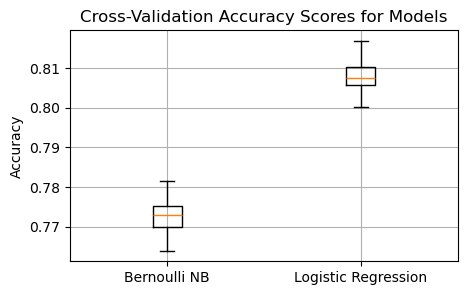

In [40]:
plt.figure(figsize=(5, 3))
plt.boxplot([bernoulli_nb_scores, logistic_regression_scores],
            labels=['Bernoulli NB', 'Logistic Regression'])
plt.title('Cross-Validation Accuracy Scores for Models')
plt.ylabel('Accuracy')
plt.grid()
plt.show()